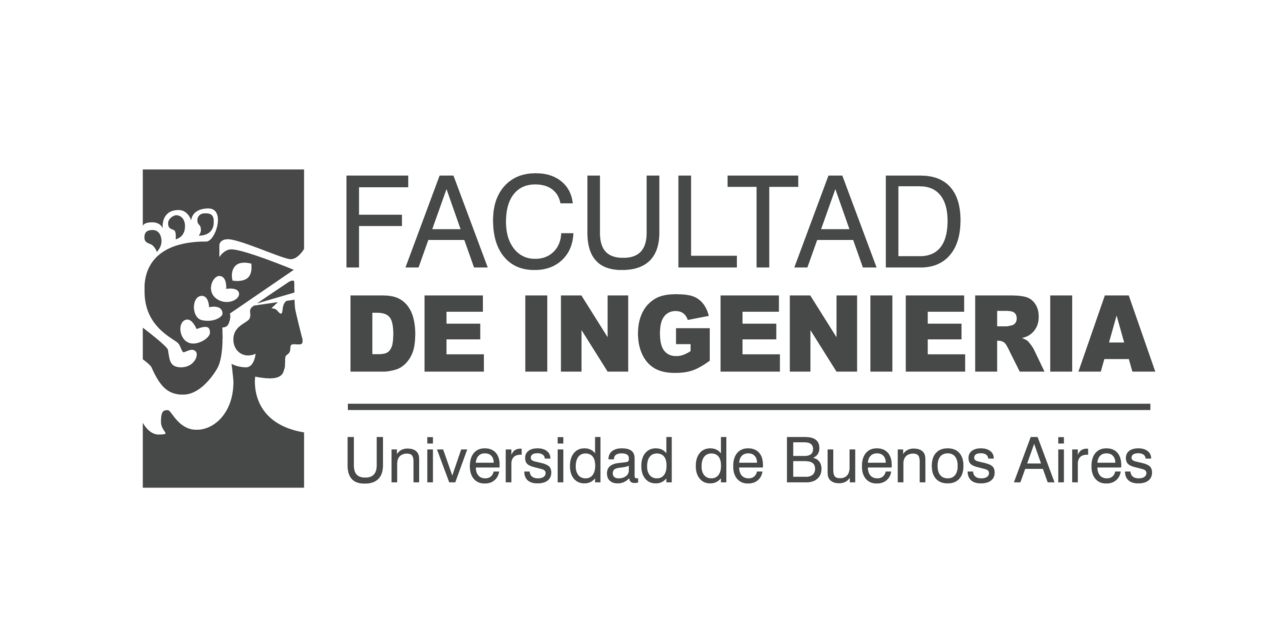

**Profesores:** <br />
Ing. Maxim Dorogov - mdorogov@fi.uba.ar <br />
Esp. Ing. Leandro Torrent - ingtorrentleandro@gmail.com <br />

**Alumnos:** <br />
Ing. Pablo Martin Gomez Verdini - gomezpablo86@gmail.com <br />
Ing. Diego Paciotti Iacchelli - diegopaciotti@gmail.com  <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/FIUBA-CEIA-18Co2024/VpC1-TP2 <br />

# TP 2: Enunciado

### Objetivo:
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.
1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper"Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
Para cada experimento se debe presentar :
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

Puntos extra: Aplicar unsharp masking para expandir la zona de enfoque y devolver.

# Desarrollo
### Algorithm for Image Quality Measure (3.1 Image Sharpness Measure for Blurred Images in Frequency Domain)

- **Input:**  
  Image $I$ of size $M \times N$.

- **Output:**  
  Image Quality measure $\text{FM}$ (Frequency Domain Image Blur Measure).

---

**Step 1:** Compute $F$, the Fourier transform of image $I$.  
**Step 2:** Find $F_c$, which is obtained by shifting the center of the spectrum.  
**Step 3:** Calculate $\text{AF} = |F_c|$, where $\text{AF}$ is the absolute value of the centered Fourier transform of image $I$.  
**Step 4:** Calculate $M = \max(\text{AF})$, the maximum value of the frequency component in $F$.  
**Step 5:** Calculate $T_{\text{th}}$, the number of pixels in $F$ whose pixel value is greater than $\text{thres}$, where $\text{thres} = \frac{M}{1000}$.  
**Step 6:** Calculate the Image Quality measure $\text{FM}$ from Equation (1).

$$
\text{FM} = \frac{T_{\text{th}}}{M \times N} \quad (1)
$$


### Imports

In [46]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### Funciones útiles

In [47]:
def mostrar_imagen(imagen: cv2.typing.MatLike, titulo: str = ''):
    """
    Muestra una imagen utilizando matplotlib.

    :param imagen: La imagen a mostrar, debe ser un array de numpy.
    :param titulo: Título de la imagen.
    """
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

def get_frame(video: cv2.VideoCapture, n_frame: int, display: bool = True):
    """
    Obtiene un frame específico de un video y lo muestra.

    :param video: El objeto de video de OpenCV.
    :param n_frame: Número del frame a obtener.
    :param display: Si es True, muestra el frame obtenido.
    :return: El frame obtenido.
    """
    video.set(cv2.CAP_PROP_POS_FRAMES, n_frame)
    ret, frame = video.read()
    if display:
        mostrar_imagen(frame, titulo=f'Frame numero {n_frame}')
    return frame

def quality_measure(image: cv2.typing.MatLike) -> float:
    """
    Calcula la métrica de calidad de imagen utilizando el algoritmo definido en
    el paper "Image Sharpness Measure for Blurred Images in Frequency Domain ".

    :param image: La imagen a analizar, debe ser un array de numpy.
    :return: La métrica de calidad de imagen calculada.
    """
    # Convertir a escala de grises si es necesario
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image    
    # Paso 1: Calcular la FFT 
    f = np.fft.fft2(gray)
    # Paso 2: Buscar el centro del espectro
    fc = np.fft.fftshift(f)
    # Paso 3: Calcular el espectro de magnitud
    AF = np.abs(fc)
    # Paso 4: Calcular el espectro de magnitud
    M = np.max(AF)
    # Paso 5: Definir el umbral basado en la magnitud del espectro
    threshold = M / 1000
    T_th = np.sum(AF > threshold)
    # Paso 6: 
    # Obtener dimensiones de la imagen
    rows, cols = gray.shape
    N_total = rows * cols
    # Calcular la métrica de calidad de imagen
    FM = T_th / (M * N_total)
    return FM

def obtener_roi(frame: cv2.typing.MatLike, ratio: float = 0.10, display: bool = False) -> cv2.typing.MatLike:
    """
    Obtener una región de interés (ROI) de un frame y opcionalmente mostrarla 
    en el centro del mismo.

    :param frame: El frame de video en el que se dibujará la ROI.
    :param ratio: El ratio del área de la ROI respecto al área total del frame.
    :param display: Si es True, muestra el frame junto a la ROI calculada.
    :raises ValueError: Si el ratio no está entre 0 y 1 (exclusivo).
    :return: Región de interés.
    """
    if ratio <= 0 or ratio >= 1:
        raise ValueError("El ratio debe estar entre 0 y 1 (exclusivo).")
    # Obtener las dimensiones del frame
    H, W = frame.shape[:2]
    # Calcular las dimensiones de la ROI
    roi_width = int(np.sqrt(ratio) * W)
    roi_height = int(np.sqrt(ratio) * H)
    # Calcular la posición para centrar la ROI
    start_x = (W - roi_width) // 2
    start_y = (H - roi_height) // 2
    # Extraer la ROI (opcional, para verificar)
    roi = frame[start_y:start_y+roi_height, start_x:start_x+roi_width]
    if display:
        # Dibujar un rectángulo en el frame original para visualizar la ROI
        frame_con_roi = frame.copy()
        cv2.rectangle(
            img=frame_con_roi,
            pt1=(start_x, start_y),
            pt2=(start_x + roi_width, start_y + roi_height),
            color=(0, 255, 0),
            thickness=2
        )
        # Mostrar la imagen con la ROI utilizando matplotlib
        plt.figure(figsize=(12, 6))
        # Convertir de BGR a RGB para mostrar correctamente el color
        plt.imshow(cv2.cvtColor(frame_con_roi, cv2.COLOR_BGR2RGB))
        plt.title(f'Frame con ROI central ({ratio*100}% del área total)')
        plt.axis('off')
        plt.show()
    return roi

### Experimento 1: Medición sobre todo el frame.

In [48]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

# Listas para almacenar la evolución de la métrica en cada frame
metrics_full = []  # Métrica para el frame completo
frame_numbers = [] # Número de frame
frame_index = 0

while captura_video.isOpened():
    ret, frame = captura_video.read()
    if not ret:
        break    
    # Registrar número de frame
    frame_numbers.append(frame_index)
    # --- Experimento 1: Métrica en todo el frame ---
    metric_full = quality_measure(frame)
    metrics_full.append(metric_full)
    frame_index += 1

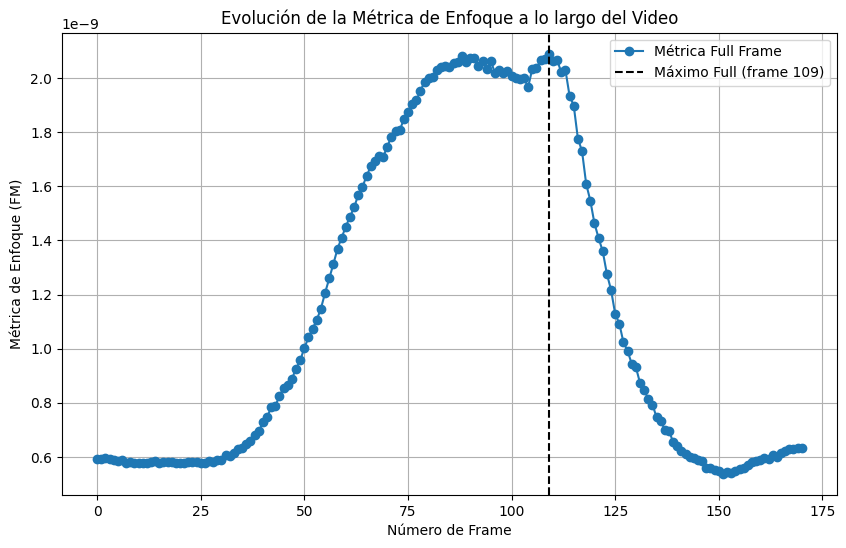

Máximo enfoque (Frame Completo) en frame: 109 con valor 2.090055687668118e-09


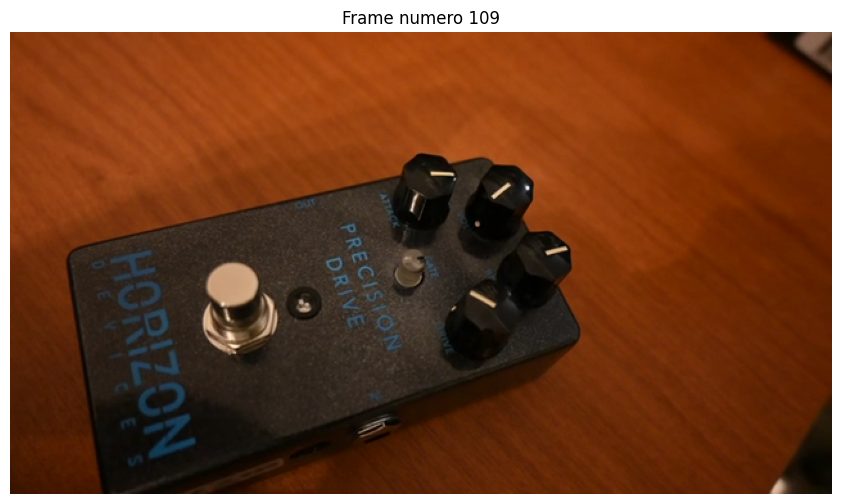

In [49]:
# Convertir listas a arreglos de numpy (opcional)
metrics_full = np.array(metrics_full)
frame_numbers = np.array(frame_numbers)

# Detectar los frames con máximo enfoque
max_full_index = np.argmax(metrics_full)

# --- Visualización de Resultados ---
plt.figure(figsize=(10, 6))
plt.plot(frame_numbers, metrics_full, label="Métrica Full Frame", marker='o', linestyle='-')
plt.axvline(x=frame_numbers[max_full_index], color='black', linestyle='--', 
            label=f'Máximo Full (frame {max_full_index})')
plt.xlabel("Número de Frame")
plt.ylabel("Métrica de Enfoque (FM)")
plt.title("Evolución de la Métrica de Enfoque a lo largo del Video")
plt.legend()
plt.grid(True)
plt.show()

print(f"Máximo enfoque (Frame Completo) en frame: {max_full_index} con valor {np.max(metrics_full)}")
get_frame(captura_video, max_full_index)
# Libera el objeto de captura de video
captura_video.release()
cv2.destroyAllWindows()

### Experimento 2: Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.

In [50]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

# Listas para almacenar la evolución de la métrica en cada frame
metrics_roi = []   # Métrica para la ROI central
frame_numbers = [] # Número de frame
frame_index = 0

while captura_video.isOpened():
    ret, frame = captura_video.read()
    if not ret:
        break
    # Registrar número de frame
    frame_numbers.append(frame_index)
    # --- Experimento 2: Métrica en una ROI central ---
    # Definir ROI: utilizar 10% del área total del frame
    roi = obtener_roi(frame, ratio=0.10)    
    metric_roi = quality_measure(roi)
    metrics_roi.append(metric_roi)    
    frame_index += 1

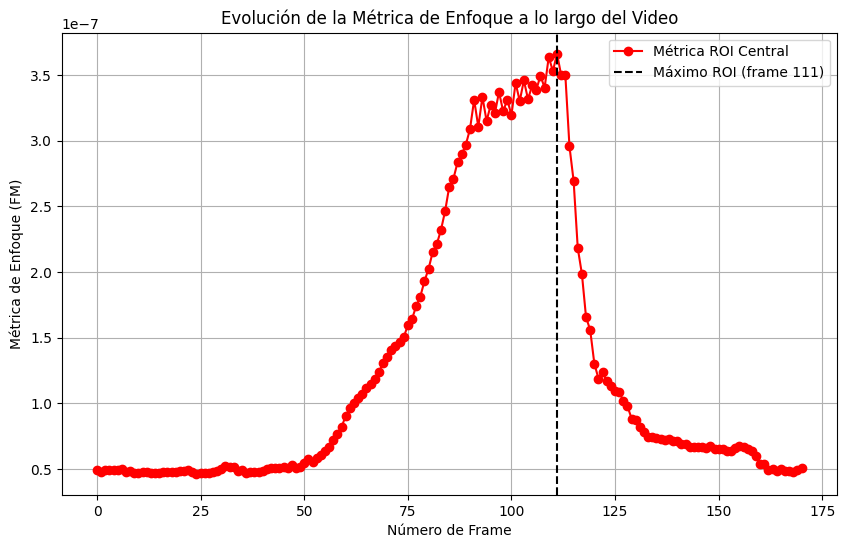

Máximo enfoque (ROI Central) en frame: 111 con valor 3.6628938372355446e-07


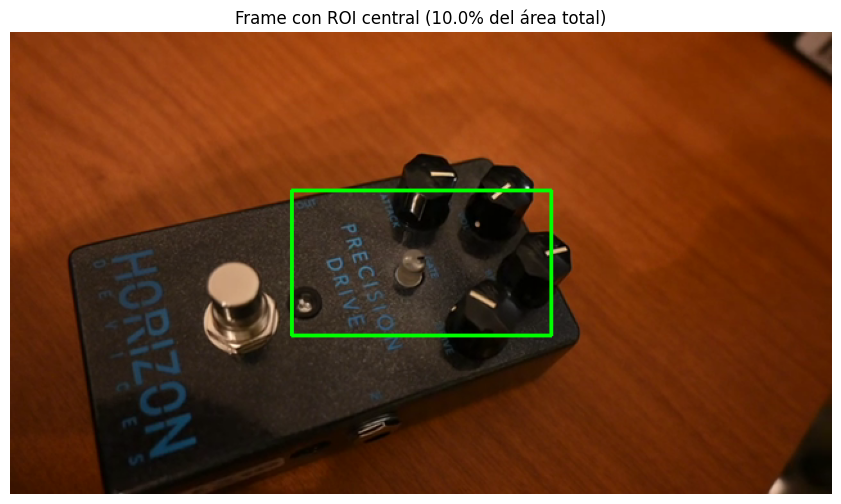

In [51]:
metrics_roi = np.array(metrics_roi)
max_roi_index = np.argmax(metrics_roi)
frame_numbers = np.array(frame_numbers)

# --- Visualización de Resultados ---
plt.figure(figsize=(10, 6))
plt.plot(frame_numbers, metrics_roi, label="Métrica ROI Central", marker='o', linestyle='-', color='red')
plt.axvline(x=frame_numbers[max_roi_index], color='black', linestyle='--', 
            label=f'Máximo ROI (frame {max_roi_index})')
plt.xlabel("Número de Frame")
plt.ylabel("Métrica de Enfoque (FM)")
plt.title("Evolución de la Métrica de Enfoque a lo largo del Video")
plt.legend()
plt.grid(True)
plt.show()

print(f"Máximo enfoque (ROI Central) en frame: {max_roi_index} con valor {np.max(metrics_roi)}")
obtener_roi(get_frame(captura_video, max_roi_index, display=False), display=True)
# Libera el objeto de captura de video
captura_video.release()
cv2.destroyAllWindows()

### Extra: aplicar unsharp masking para expandir la zona de enfoque y devolver.

In [ ]:
def unsharp_mask(image: cv2.typing.MatLike, kernel_size: tuple = (5,5), sigma: float = 1.0, amount: float = 1.0, threshold: int  = 0) -> cv2.typing.MatLike:
    """
    Aplica un filtro de enmascaramiento de desenfoque (unsharp mask) a una imagen.

    :param image: La imagen a la que se le aplicará el filtro.
    :param kernel_size: Tamaño del kernel para el desenfoque.
    :param sigma: Desviación estándar para el desenfoque Gaussiano.
    :param amount: Cantidad de desenfoque a aplicar.
    :param threshold: Umbral para la máscara de desenfoque.
    :return: La imagen resultante después de aplicar el filtro.
    """
    # Aplicar desenfoque Gaussiano
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    # Combinar la imagen original con la máscara (la diferencia entre original y desenfocada)
    # sharpened = (1 + amount) ⋅ image − amount ⋅ blurred
    sharpened = cv2.addWeighted(image, 1 + amount, blurred, -amount, 0)    
    if threshold > 0:
        # Para píxeles donde la diferencia es menor al umbral, se deja sin modificar.
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

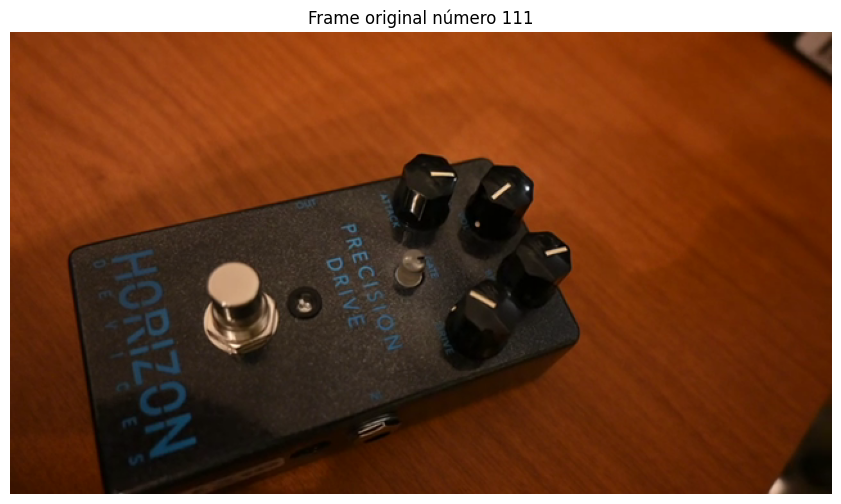

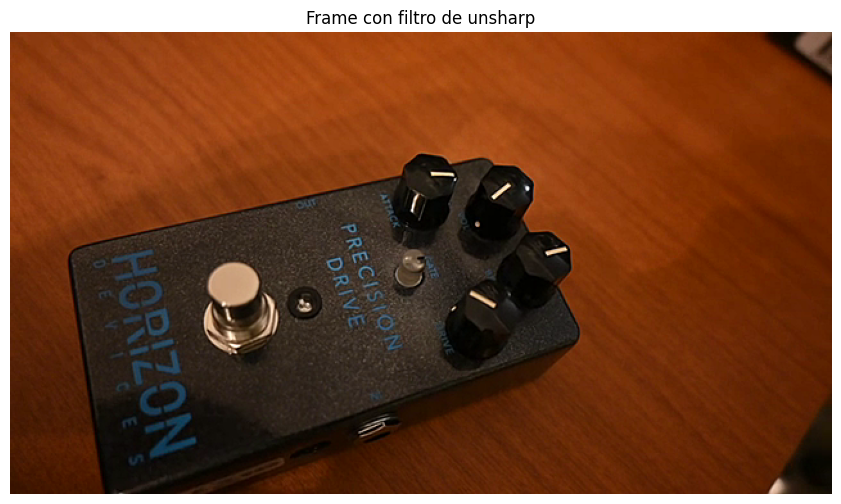

In [ ]:
captura_video = cv2.VideoCapture(video_path)
best_index = max_roi_index
best_frame = get_frame(captura_video, best_index, display=False)
# --- Aplicar Unsharp Masking en el frame con máximo enfoque ---
if best_frame is not None:
    sharpened_frame = unsharp_mask(best_frame, kernel_size=(5,5), sigma=1.0, amount=1.0, threshold=0)    
    mostrar_imagen(best_frame, titulo= f"Frame original número {best_index}")
    mostrar_imagen(sharpened_frame, titulo= "Frame con filtro de unsharp")
captura_video.release()
cv2.destroyAllWindows()